![example](images/director_shot.jpeg)

# Project Title 2010-2018

**Author:** Brent Smart
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

As Microsoft enters the movie production industry, this data analysis aims to answer the following questions:

* What is the average gross by genre?
* What is the average run-time by genre?
* What type of movies does each studio produce?
* (MVP 2) - add forth question about foreign vs domestic markets.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
The data in this analysis comes from two primary sources: 
* IMDb for basic movie information
* Movie gross data from bom.movie_gross (VERIFY SOURCE)

The data in this analysis only represents movies with both studio and gross information and in most cases specified movie genres.

Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions? 
* What do the data represent? Who is in the sample and what variables are included? 
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [361]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 

%matplotlib inline

In [236]:
# Here you run your code to explore the data
df_gross = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
df_ratings = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
df_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')

# Checking structure
df_basics.info()
df_gross.info() 
df_ratings.info()  

# Finding max and min of years and ratings
df_basics.start_year.max() #2115 
df_basics.start_year.min() #2010
df_gross.year.max() #2018 
df_gross.year.min() #2010
df_ratings.averagerating.max() #10.0 
df_ratings.averagerating.min() #1.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), o

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Since this analysis' aim is to make recommendations on movies genres and studio performance, a variable combining domestic and foreign gross data was created. Movies without this information were removed from this analysis. To account for the gross of movies produced by studios with no specified genre, those movies were labeled with "unspecified_genre".

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers? 
* Why are these choices appropriate given the data and the business problem? 
***

In [364]:
# Here you run your code to clean the data
# Cleaning punction
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
transtab = str.maketrans(dict.fromkeys(punct,''))


# Clean df_basics small since chunk of genres missing, replaced with unknown. 
# Removed punction and turned all to lower case.
df_basics['genres'].fillna('Unspecified', inplace=True)
df_basics.primary_title = df_basics.primary_title.apply(lambda x: x.lower())
df_basics.primary_title = '|'.join(df_basics.primary_title.tolist()).translate(transtab).split('|')

# Nan runtime changes to 0
df_basics['runtime_minutes'].fillna(0, inplace=True)

#clean gross, only a few missing studios replaced with unspecified_genre.
df_gross['studio'].fillna('unspecified_genre', inplace=True)
df_gross.title = df_gross.title.apply(lambda x: x.lower())
df_gross.title = '|'.join(df_gross.title.tolist()).translate(transtab).split('|')
df_gross.studio = df_gross.studio.apply(lambda x: x.upper())
df_gross.studio = '|'.join(df_gross.studio.tolist()).translate(transtab).split('|')

df_1 = pd.merge(df_basics, df_gross, left_on='primary_title', right_on='title', how='outer')
df = pd.merge(df_1, df_ratings, on='tconst', how='outer')

df.foreign_gross = df.foreign_gross.str.replace(',','')
df.foreign_gross = df.foreign_gross.astype(float)
df['total_gross_millions'] = (df['domestic_gross'] + df['foreign_gross'])/1000000

# data only includes 2010-2018 moves with budget and genre information. Nan removed.
df = df.loc[(df['year'] >= 2010) & (df['year'] <= 2018)].sort_values(by='primary_title', ascending=False)
df = df[(df['genres'].notna()) & (df['total_gross_millions'].notna()) & (df['studio'].notna())]
col_to_drop = ['tconst', 'original_title','title', 'year', 'start_year','averagerating', 'numvotes']
df.drop(col_to_drop, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

#check for duplicates
df.drop_duplicates(subset=['primary_title', 'domestic_gross', 'foreign_gross'], keep='first', inplace=True, )

df.head(25)

,primary_title,runtime_minutes,genres,studio,domestic_gross,foreign_gross,total_gross_millions
0,zootopia,108.0,"Adventure,Animation,Comedy",BV,341300000.0,682500000.0,1023.8000
1,zoolander 2,101.0,Comedy,PAR,28800000.0,27900000.0,56.7000
2,zookeeper,102.0,"Comedy,Family,Romance",SONY,80400000.0,89500000.0,169.9000
3,zero dark thirty,157.0,"Drama,Thriller",SONY,95700000.0,37100000.0,132.8000
4,yves saint laurent,106.0,"Biography,Drama",WEIN,724000.0,20300000.0,21.0240
5,your name,106.0,"Animation,Drama,Fantasy",FUN,5000000.0,353000000.0,358.0000
6,your highness,102.0,"Adventure,Comedy,Fantasy",UNI,21600000.0,3300000.0,24.9000
7,young goethe in love,102.0,"Drama,Romance",MBOX,162000.0,5600000.0,5.7620
8,young detective dee rise of the sea dragon,134.0,"Action,Adventure,Drama",WAMCR,87800.0,72200000.0,72.2878
9,young adult,94.0,"Comedy,Drama",PAR,16300000.0,6600000.0,22.9000


In [385]:
# count of num 2010-2018 by genere 
count_by_genre = df.groupby(['genres']).size().to_frame('count').reset_index()
count_by_genre

# # gross and runtine by genre for movies 2010-2018 
gross_by_time = df.groupby(['runtime_minutes','genres'])['total_gross_millions'].mean().sort_values(ascending=False).reset_index()
gross_by_time

# # average gross by movie studios for movies 2010-2018 
gross_by_studio = df.groupby(['studio'])['total_gross_millions'].mean().sort_values(ascending=False).reset_index()
gross_by_studio

# # average gross by studio and genere for movies 2010-2018 
gross_by_studio_genre = df.groupby(['studio', 'genres'])['total_gross_millions'].mean().sort_values(ascending=False).reset_index()
gross_by_studio_genre



# check
# genres = df.genres.unique()
# len(genres)  #282 after removing non-budget ones.
# studios = df.studio.unique()
# len(studios) #150 after removing non-budget & non-genre ones.

,studio,genres,total_gross_millions
0,WB,"Adventure,Drama,Fantasy",1341.5000
1,BV,"Adventure,Drama,Sport",1276.4000
2,PDW,"Action,Adventure,Sci-Fi",1123.8000
3,WB,"Action,Thriller",1084.9000
4,WB NL,"Adventure,Family,Fantasy",1021.1000
...,...,...,...
1087,ITL,Documentary,0.0529
1088,WOW,Documentary,0.0494
1089,STRAND,Horror,0.0387
1090,CRNTH,Drama,0.0383


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

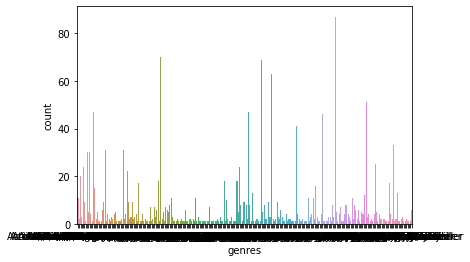

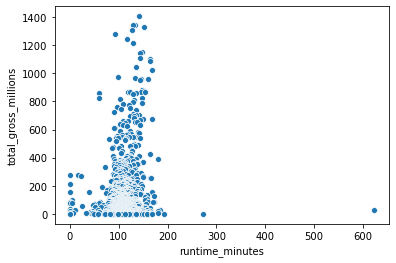

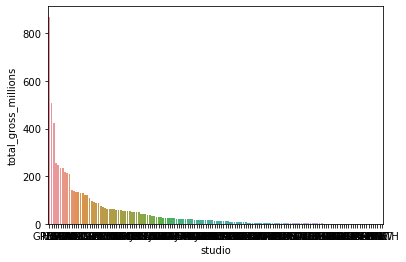

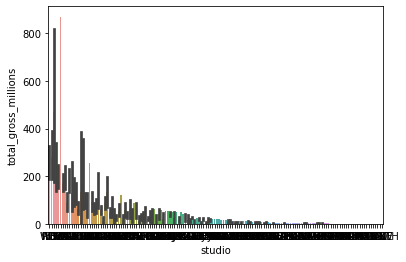

In [386]:
# Here you run your code to model the data
#count_by_genre
plt.figure()
sns.barplot(x="genres",
            y="count",
            data=count_by_genre)

#gross_by_time - Need to come back to outliers. Remove them.
plt.figure()
sns.scatterplot(x="runtime_minutes",
                y="total_gross_millions",
                data=gross_by_time)

#gross_by_studio
plt.figure()
sns.barplot(x="studio",
            y="total_gross_millions",
            data=gross_by_studio)

# gross_by_studio_genre
plt.figure()
sns.barplot(x="studio",
            y="total_gross_millions",
            data=gross_by_studio_genre)

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***